In [1]:
#%config Completer.use_jedi = False
import os
import sys
sys.path.append('..')


from pprint import pprint    
import tensorflow as tf    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from tndm.data import DataManager
from tndm import LFADS
from tndm.runtime import Runtime
from typing import Dict, Any
from sklearn.linear_model import Ridge

from plotting import *

In [2]:
# read the data/disk/scratch/cole/Chewie_CO_FF_2016-10-07_pos_M1_spikes/test_data/
spike_data_dir = "Chewie_CO_FF_2016-10-07_pos_M1_spikes/"

data_dir = os.path.join( spike_data_dir )

dataset, settings = DataManager.load_dataset(
    directory=data_dir,
    filename='dataset.h5')

#train
neural_data = dataset['train_data'].astype('float')
behavioural_data = dataset['train_behaviours'].astype('float')

# valid
valid_neural_data = dataset['valid_data'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')

# test
test_neural_data = dataset['test_data'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

# get dataset, to train by myself
# with_behaviour = False for lfads
# target = input for reconstruction

In [3]:
(x_train, y_train), (x_val, y_val) = Runtime.clean_datasets(
            train_dataset=(neural_data, behavioural_data), 
            val_dataset=(valid_neural_data, valid_behavioural_data), 
            with_behaviour=False
            )

In [4]:
x_test = test_neural_data
y_test = test_behavioural_data

In [5]:
def print_data_shape(data):
    if data is not None:
        print(data.shape)
    else:
        print("None")

In [6]:
print_data_shape(x_train)
print_data_shape(y_train)
print_data_shape(x_val)
print_data_shape(y_val)
print_data_shape(x_test)
print_data_shape(y_test)

(136, 73, 70)
None
(17, 73, 70)
None
(17, 73, 70)
(17, 73, 2)


# Quantize data first
## the input and last layer will remain ap<16,6> precision

In [7]:
AP_BITS = 16
AP_INTS = 6

In [8]:
# ususal quantize
from qkeras import QActivation
ACTIVATION_BITS = "quantized_bits({},{},alpha=1)".format(AP_BITS, AP_INTS-1)

In [9]:
'''
total_data = [x_train, y_train, x_val, y_val, x_test, y_test]

for index, d in enumerate(total_data):
    print("index: ", index)
    if d is None:
        print("None")
    else:                
        print("before quantization min/max: {} / {}".format(d.min(), d.max()))
        q_d = QActivation(ACTIVATION_BITS)(d)
        q_d_numpy = q_d.numpy()
        print("after quantization min/max: {} / {}".format(q_d_numpy.min(), q_d_numpy.max()))
        total_data[index] = q_d_numpy
    
[x_train, y_train, x_val, y_val, x_test, y_test] = total_data    
'''

'\ntotal_data = [x_train, y_train, x_val, y_val, x_test, y_test]\n\nfor index, d in enumerate(total_data):\n    print("index: ", index)\n    if d is None:\n        print("None")\n    else:                \n        print("before quantization min/max: {} / {}".format(d.min(), d.max()))\n        q_d = QActivation(ACTIVATION_BITS)(d)\n        q_d_numpy = q_d.numpy()\n        print("after quantization min/max: {} / {}".format(q_d_numpy.min(), q_d_numpy.max()))\n        total_data[index] = q_d_numpy\n    \n[x_train, y_train, x_val, y_val, x_test, y_test] = total_data    \n'

# model parameters

In [10]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
#initial_neural_weight = 1.0 # weight of neural nll
#initial_behaviour_weight = .2 # weight of behaviour loss
#lambda_q = 100.0
#update_rate = .0005
dropout = .15
#seed = 0
#GRU_pre_activation = False
#var_min = 0.0001
#prior_variance = 1
threshold_poisson_log_firing_rate = 100.


layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [11]:
pprint(layers_settings)

defaultdict(<function <lambda> at 0x000001ABEB859EE0>,
            {'decoder': {'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling object at 0x000001ABEB872F10>,
                         'kernel_regularizer': <keras.regularizers.L2 object at 0x000001ABEB8710D0>,
                         'original_cell': False,
                         'recurrent_regularizer': <keras.regularizers.L2 object at 0x000001ABEB871130>}})


In [12]:
layers_settings['encoder']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x1abea2165b0>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x1aba81cfa30>}

In [13]:
layers_settings['decoder']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x1abeb872f10>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x1abeb8710d0>,
 'recurrent_regularizer': <keras.regularizers.L2 at 0x1abeb871130>,
 'original_cell': False}

In [14]:
layers_settings['dense_mean']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x1abea216760>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x1abea2164f0>}

# input for decoder GRU
# Assuming inputs are zero and everything comes from the GRU

In [15]:
decoder_dim = 64

In [16]:
def get_decoder_input(decoder_dim=64):
    inputs2decoder_train = tf.stack([tf.zeros_like(x_train)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_val = tf.stack([tf.zeros_like(x_val)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_test = tf.stack([tf.zeros_like(x_test)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_train = np.array(inputs2decoder_train)
    inputs2decoder_val = np.array(inputs2decoder_val)
    inputs2decoder_test = np.array(inputs2decoder_test)
    print("inputs2decoder_train shape: ", inputs2decoder_train.shape)
    print("inputs2decoder_val shape: ", inputs2decoder_val.shape)
    print("inputs2decoder_test shape: ", inputs2decoder_test.shape)
    return inputs2decoder_train, inputs2decoder_val, inputs2decoder_test

In [17]:
inputs2decoder_train, inputs2decoder_val, inputs2decoder_test = get_decoder_input(decoder_dim=64)

inputs2decoder_train shape:  (136, 73, 64)
inputs2decoder_val shape:  (17, 73, 64)
inputs2decoder_test shape:  (17, 73, 64)


# loss: poisson_loglike_loss

In [18]:
timestep = 0.01

def poisson_loglike_loss(y_true, y_pred):    
    # POISSON LOG-LIKELIHOOD
    # clip the y_pred first
    y_pred = tf.clip_by_value(y_pred, 
                                     clip_value_min=-threshold_poisson_log_firing_rate,
                                     clip_value_max=threshold_poisson_log_firing_rate
                             )
    targets = tf.cast(y_true, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(timestep) + y_pred, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(
        targets=targets,
        log_input=logrates, compute_full_loss=True
    )
    #print(npll.shape)
    loss = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    loss = tf.reduce_mean(loss) # batch mean
    #loss = tf.reduce_sum()
    return loss

In [19]:
def evaluate_NPLL(targets, pred_logrates):
    targets = tf.cast(targets, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(0.01) + pred_logrates, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(targets=targets,log_input=logrates, compute_full_loss=True)
    results = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    results = tf.reduce_mean(results) # batch mean

    print(results) # negative possion loglikelihood
    return results

In [20]:
from tensorflow.keras.models import load_model

In [21]:
fmodel = load_model("lfadfp.h5", compile = False)

In [22]:
fmodel.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_24[0][0]']               
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                           

In [23]:
evaluate_NPLL(targets=x_test, pred_logrates=fmodel.predict([x_test, inputs2decoder_test]))

C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


tf.Tensor(1810.0365, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=1810.0365>

In [24]:
np.array_equal(x_test, test_neural_data)

True

In [25]:
np.array_equal(x_train, neural_data)

True

# load quantized weights

# load pretrained qmodel

In [26]:
from qkeras.utils import load_qmodel, model_save_quantized_weights

## 8 bits

# Eval test NPLL

In [27]:
model_8bits = load_qmodel("lfad8bitssgd_qweights.h5",compile=False)
model_8bits.summary()

[20:07:54.816] INFO [root.safe_eval:134] keras dict linear
[20:07:54.823] INFO [root.safe_eval:134] keras dict linear
[20:07:54.826] INFO [root.safe_eval:134] keras dict linear
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_1[0][0]']                
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
              

In [44]:
print("eval: {} bits".format(8))
pred_logf = model_8bits.predict([x_test, inputs2decoder_test])
print(pred_logf.shape)
npll = evaluate_NPLL(targets=x_test, pred_logrates=pred_logf)



eval: 8 bits


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


(17, 73, 70)
tf.Tensor(1827.4061, shape=(), dtype=float32)


In [28]:
#total = list(range(4,16+2,2))

In [29]:
#total

[4, 6, 8, 10, 12, 14, 16]

In [97]:
npll_list = []
for tot in total:
    model = load_qmodel(f"lfad{tot}bitssgd_qweights.h5",compile=False)
    print("eval: {} bits".format(tot))
    model.summary()
    pred_logf = model.predict([x_test, inputs2decoder_test])
    print(pred_logf.shape)
    npll = evaluate_NPLL(targets=x_test, pred_logrates=pred_logf)
    npll_list.append(npll)
    print()

[00:02:42.514] INFO [root.safe_eval:134] keras dict linear
[00:02:42.521] INFO [root.safe_eval:134] keras dict linear
[00:02:42.526] INFO [root.safe_eval:134] keras dict linear
eval: 4 bits
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_1[0][0]']                
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
   

 nerual_dense (QDense)          (None, 73, 70)       350         ['q_act3_postfactor[0][0]']      
                                                                                                  
 qact_logf_out (QActivation)    (None, 73, 70)       0           ['nerual_dense[0][0]']           
                                                                                                  
Total params: 86,046
Trainable params: 86,046
Non-trainable params: 0
__________________________________________________________________________________________________
(17, 73, 70)
tf.Tensor(1861.1278, shape=(), dtype=float32)

[00:02:48.874] INFO [root.safe_eval:134] keras dict linear
[00:02:48.881] INFO [root.safe_eval:134] keras dict linear
[00:02:48.883] INFO [root.safe_eval:134] keras dict linear
eval: 10 bits
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Con

                                                                                                  
 postdecoder_dropout (Dropout)  (None, 73, 64)       0           ['q_act_postdecoder[0][0]']      
                                                                                                  
 dense_factor (QDense)          (None, 73, 4)        256         ['postdecoder_dropout[0][0]']    
                                                                                                  
 q_act3_postfactor (QActivation  (None, 73, 4)       0           ['dense_factor[0][0]']           
 )                                                                                                
                                                                                                  
 nerual_dense (QDense)          (None, 73, 70)       350         ['q_act3_postfactor[0][0]']      
                                                                                                  
 qact_logf

 input_2 (InputLayer)           [(None, 73, 64)]     0           []                               
                                                                                                  
 q_act_postdense_latent (QActiv  (None, 64)          0           ['dense_latent[0][0]']           
 ation)                                                                                           
                                                                                                  
 DecoderGRU (QGRU)              (None, 73, 64)       24960       ['input_2[0][0]',                
                                                                  'q_act_postdense_latent[0][0]'] 
                                                                                                  
 q_act_postdecoder (QActivation  (None, 73, 64)      0           ['DecoderGRU[0][0]']             
 )                                                                                                
          

In [95]:
npll_list

[<tf.Tensor: shape=(), dtype=float32, numpy=1876.8479>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1861.1278>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1814.2063>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1814.2329>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1811.5416>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1812.858>]

In [45]:
# for plotting
d_all = np.concatenate((dataset['train_target_direction'], dataset['test_target_direction'], dataset['valid_target_direction']))
d = dataset['train_target_direction']
direction_index_train = np.array([sorted(set(d_all)).index(i) for i in d])
d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d_all)).index(i) for i in d])
direction_index_all = np.concatenate((direction_index_test, direction_index_train))

# PCA latent

In [30]:
from tensorflow.keras import Model

In [74]:
from sklearn.decomposition import PCA

## fpmodel

(17, 64)


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Text(0.5, 1.0, 'Factors of fp')

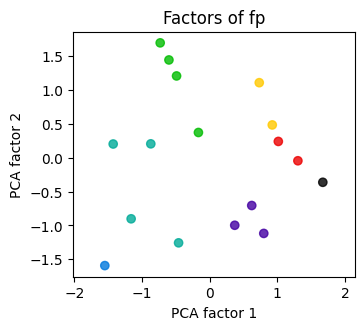

In [86]:
latent_layer = fmodel.get_layer("dense_latent")
latent_model = Model(fmodel.inputs, latent_layer.output)
pred_latent =  latent_model.predict([x_test, inputs2decoder_test])
print(pred_latent.shape)
plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(pred_latent)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_test])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors of fp')

## 8bits model

(17, 64)


Text(0.5, 1.0, 'Factors of 8bits')

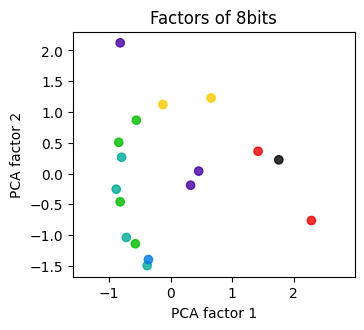

In [99]:
latent_layer = model_8bits.get_layer("dense_latent")
latent_model = Model(model_8bits.inputs, latent_layer.output)
pred_latent =  latent_model.predict([x_test, inputs2decoder_test])
print(pred_latent.shape)
plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(pred_latent)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_test])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors of 8bits')

In [73]:
total = [4,6,10,12,14,16]

[00:10:40.841] INFO [root.safe_eval:134] keras dict linear
[00:10:40.849] INFO [root.safe_eval:134] keras dict linear
[00:10:40.852] INFO [root.safe_eval:134] keras dict linear
eval: 4 bits


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



[00:10:43.357] INFO [root.safe_eval:134] keras dict linear
[00:10:43.363] INFO [root.safe_eval:134] keras dict linear
[00:10:43.366] INFO [root.safe_eval:134] keras dict linear
eval: 6 bits


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



[00:10:45.596] INFO [root.safe_eval:134] keras dict linear
[00:10:45.602] INFO [root.safe_eval:134] keras dict linear
[00:10:45.605] INFO [root.safe_eval:134] keras dict linear
eval: 10 bits


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



[00:10:47.918] INFO [root.safe_eval:134] keras dict linear
[00:10:47.924] INFO [root.safe_eval:134] keras dict linear
[00:10:47.926] INFO [root.safe_eval:134] keras dict linear
eval: 12 bits


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



[00:10:50.135] INFO [root.safe_eval:134] keras dict linear
[00:10:50.142] INFO [root.safe_eval:134] keras dict linear
[00:10:50.144] INFO [root.safe_eval:134] keras dict linear
eval: 14 bits


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



[00:10:52.578] INFO [root.safe_eval:134] keras dict linear
[00:10:52.586] INFO [root.safe_eval:134] keras dict linear
[00:10:52.589] INFO [root.safe_eval:134] keras dict linear
eval: 16 bits


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


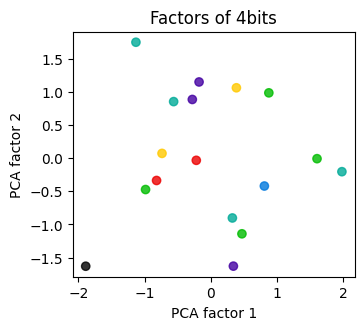

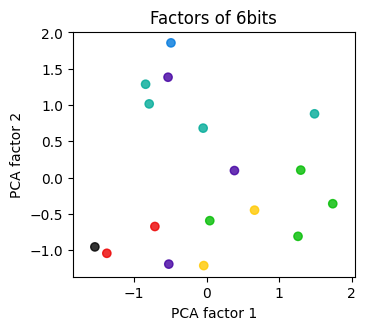

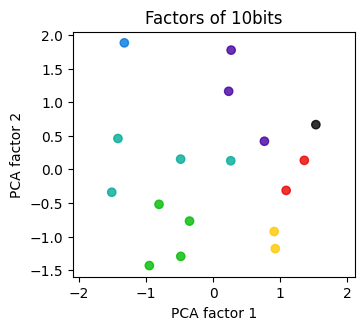

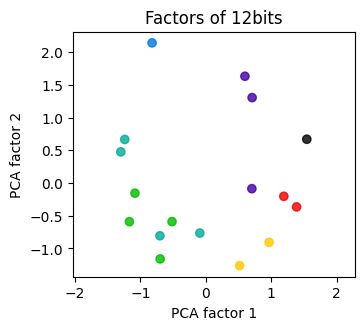

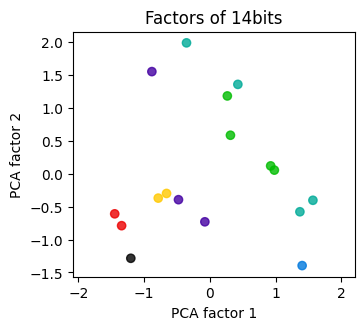

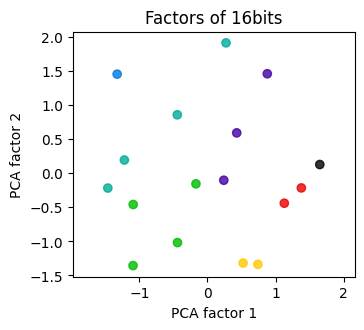

In [100]:
for tot in total:
    model = load_qmodel(f"lfad{tot}bitssgd_qweights.h5",compile=False)
    print("eval: {} bits".format(tot))
    # latent
    layer_names=list(layer.name for layer in model.layers)
    latent_layer_name = [s for s in layer_names if s.startswith('q_act_postdense_latent')][0]
    latent_layer = model.get_layer(latent_layer_name)
    latent_model = Model(model.inputs, latent_layer.output)
    pred_latent =  latent_model.predict([x_test, inputs2decoder_test])
    
    plt.figure(figsize=(8,7))
    plt.subplot(221)
    proj = PCA(n_components=2, whiten=True).fit_transform(pred_latent)
    plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_test])
    plt.axis('equal')
    plt.xlabel('PCA factor 1')
    plt.ylabel('PCA factor 2')
    plt.title(f'Factors of {tot}bits')
    

    print()

# Eval test R2

In [31]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

## fpmodel

### get factors

In [32]:
factors_layer = fmodel.get_layer("dense")
z_model = Model(fmodel.inputs,  factors_layer.output)
z_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_24[0][0]']               
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                              

In [33]:
pred_z_train =  z_model.predict([x_train, inputs2decoder_train])

### train Ridge with training data

In [58]:
X = np.transpose(pred_z_train[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z_train.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))


reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(X, y))

0.907382493651706


C:\Users\rayja\anaconda3\envs\python3816\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


### behaviour reconstruction with training data

fpmodel train behaviour R2 score : 90.738%


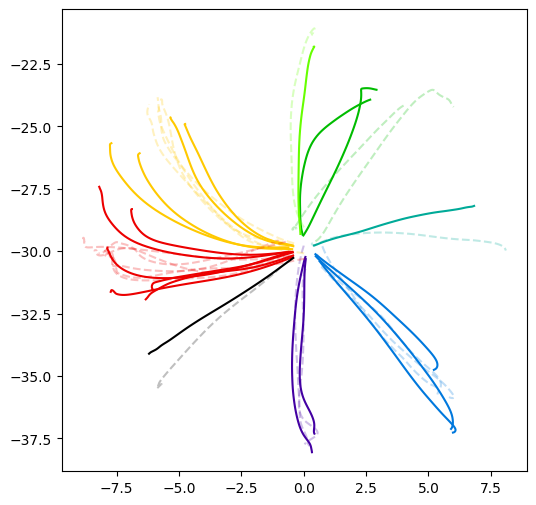

In [60]:

beh_fit = reg.predict(X)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

b_reshape = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
behavioural_data_reshape  = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
r2 = r2_score(behavioural_data_reshape , b_reshape)
print('fpmodel train behaviour R2 score : {:.3%}'.format(r2))

plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train, num=20)

### behaviour reconstruction with testing data

In [48]:
pred_z_test =  z_model.predict([x_test, inputs2decoder_test])

C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [50]:
Xt = np.transpose(pred_z_test[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z_test.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print(reg.score(Xt, yt))

0.8625788072876186


fpmodel test R2 score behaviour: 86.258%


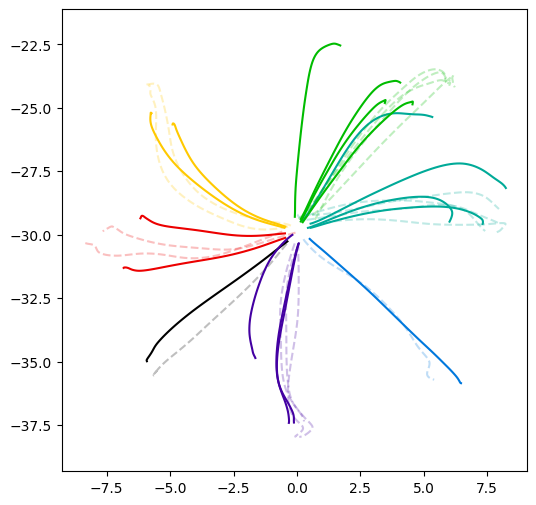

In [51]:
beh_fit_test = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit_test[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit_test[:,test_behavioural_data.shape[1]:]

Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('fpmodel test R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)

## 8bits

In [62]:
factors_layer = model_8bits.get_layer("active_bits3")
z_model = Model(model_8bits.inputs,  factors_layer.output)
z_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_1[0][0]']                
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                            

In [63]:
pred_z_train =  z_model.predict([x_train, inputs2decoder_train])

C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [64]:
pred_z_train[:5]

array([[[-4.     ,  1.15625,  1.65625,  1.09375],
        [-3.71875,  1.375  ,  2.21875,  1.28125],
        [-3.40625,  1.625  ,  2.09375,  1.21875],
        ...,
        [-2.8125 ,  1.625  ,  1.53125,  1.65625],
        [-2.78125,  1.625  ,  1.53125,  1.65625],
        [-2.78125,  1.65625,  1.53125,  1.6875 ]],

       [[-4.     ,  1.1875 ,  1.53125,  1.3125 ],
        [-4.     ,  1.71875,  2.5    ,  1.78125],
        [-4.     ,  1.5625 ,  2.0625 ,  1.375  ],
        ...,
        [-2.71875,  1.65625,  1.53125,  1.65625],
        [-2.71875,  1.6875 ,  1.53125,  1.65625],
        [-2.71875,  1.6875 ,  1.53125,  1.65625]],

       [[-4.     ,  1.34375,  1.90625,  1.6875 ],
        [-4.     ,  1.375  ,  2.4375 ,  1.6875 ],
        [-4.     ,  1.40625,  2.15625,  1.40625],
        ...,
        [-2.78125,  1.5625 ,  1.5    ,  1.65625],
        [-2.78125,  1.5625 ,  1.5    ,  1.65625],
        [-2.8125 ,  1.59375,  1.5    ,  1.6875 ]],

       [[-4.     ,  0.96875,  1.6875 ,  1.84375],
     

In [65]:
X = np.transpose(pred_z_train[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z_train.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))


reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(X, y))

0.7066513986075464


C:\Users\rayja\anaconda3\envs\python3816\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


### behaviour reconstruction with training data

8 bits train behaviour R2 score : 70.665%


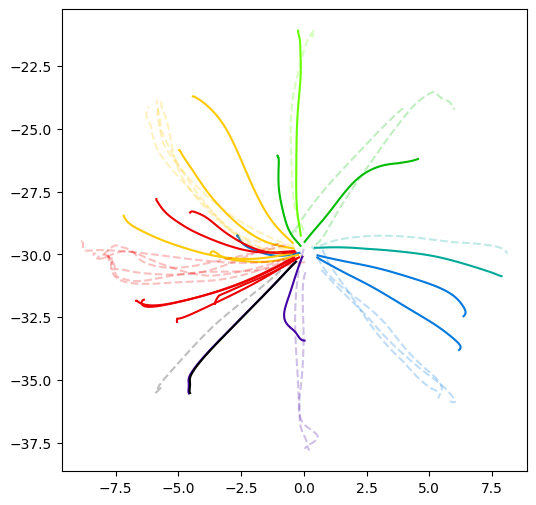

In [68]:

beh_fit = reg.predict(X)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

b_reshape = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
behavioural_data_reshape  = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
r2 = r2_score(behavioural_data_reshape , b_reshape)
print('8 bits train behaviour R2 score : {:.3%}'.format(r2))

plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train, num=20)

### behaviour reconstruction with testing data

In [69]:
pred_z_test =  z_model.predict([x_test, inputs2decoder_test])

C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [70]:
Xt = np.transpose(pred_z_test[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z_test.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print(reg.score(Xt, yt))

0.44222902875700276


8 bits test behaviour R2 score: 44.223%


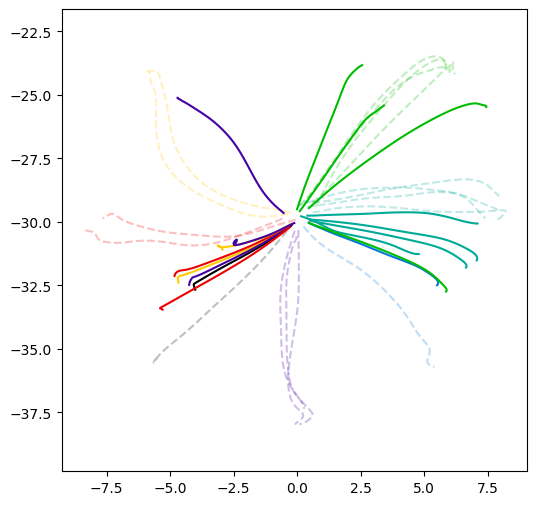

In [71]:
beh_fit_test = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit_test[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit_test[:,test_behavioural_data.shape[1]:]

Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('8 bits test behaviour R2 score: {:.3%}'.format(r2_score( yt, Xt)))

plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)

[21:40:24.447] INFO [root.safe_eval:134] keras dict linear
[21:40:24.453] INFO [root.safe_eval:134] keras dict linear
[21:40:24.456] INFO [root.safe_eval:134] keras dict linear
eval: 4 bits


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\rayja\anaconda3\envs\python3816\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fi

0.1297552383244111
4 bits R2 score train behaviour: 12.976%

-0.18337421449295502
4 bits R2 score test behaviour: -18.337%

[21:40:34.695] INFO [root.safe_eval:134] keras dict linear
[21:40:34.700] INFO [root.safe_eval:134] keras dict linear
[21:40:34.702] INFO [root.safe_eval:134] keras dict linear
eval: 6 bits


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\rayja\anaconda3\envs\python3816\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fi

0.4497497148996997
6 bits R2 score train behaviour: 44.975%

0.06569709985408122
6 bits R2 score test behaviour: 6.570%

[21:40:45.088] INFO [root.safe_eval:134] keras dict linear
[21:40:45.093] INFO [root.safe_eval:134] keras dict linear
[21:40:45.097] INFO [root.safe_eval:134] keras dict linear
eval: 10 bits


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\rayja\anaconda3\envs\python3816\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fi

0.8911403938105558
10 bits R2 score train behaviour: 89.114%

0.8135659527778659
10 bits R2 score test behaviour: 81.357%

[21:40:55.051] INFO [root.safe_eval:134] keras dict linear
[21:40:55.057] INFO [root.safe_eval:134] keras dict linear
[21:40:55.060] INFO [root.safe_eval:134] keras dict linear
eval: 12 bits


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\rayja\anaconda3\envs\python3816\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fi

0.8844891925641292
12 bits R2 score train behaviour: 88.449%

0.8537394152989989
12 bits R2 score test behaviour: 85.374%

[21:41:06.124] INFO [root.safe_eval:134] keras dict linear
[21:41:06.129] INFO [root.safe_eval:134] keras dict linear
[21:41:06.132] INFO [root.safe_eval:134] keras dict linear
eval: 14 bits


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\rayja\anaconda3\envs\python3816\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fi

0.8928781716843734
14 bits R2 score train behaviour: 89.288%

0.8388153034186713
14 bits R2 score test behaviour: 83.882%

[21:41:16.683] INFO [root.safe_eval:134] keras dict linear
[21:41:16.689] INFO [root.safe_eval:134] keras dict linear
[21:41:16.691] INFO [root.safe_eval:134] keras dict linear
eval: 16 bits


C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\rayja\anaconda3\envs\python3816\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fi

0.8816398097619312
16 bits R2 score train behaviour: 88.164%

0.8003111575002627
16 bits R2 score test behaviour: 80.031%



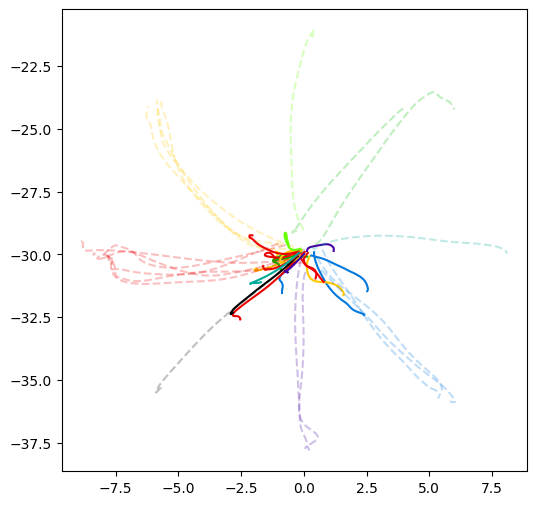

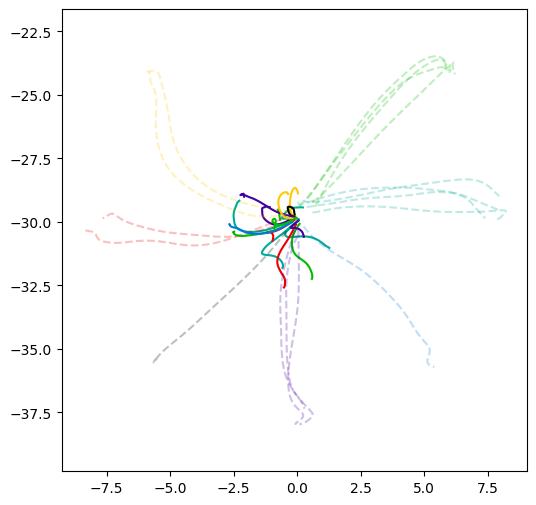

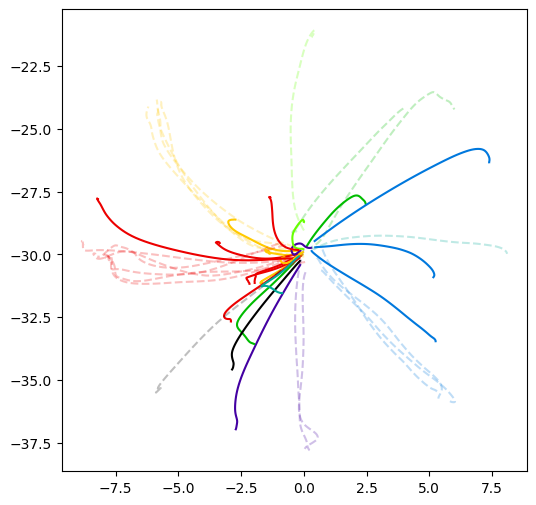

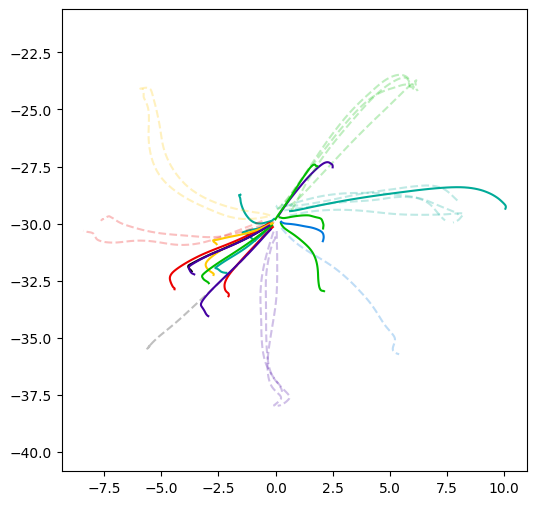

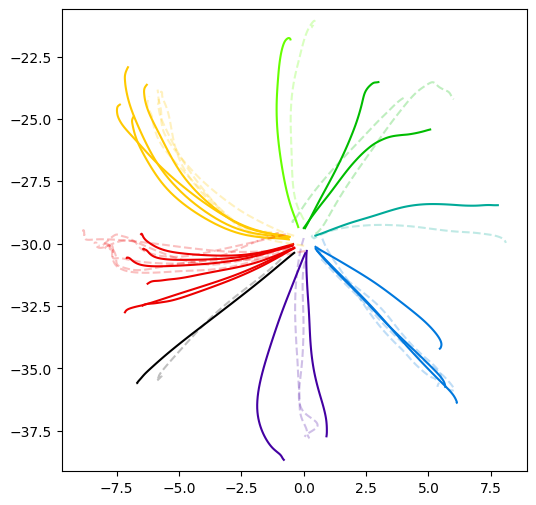

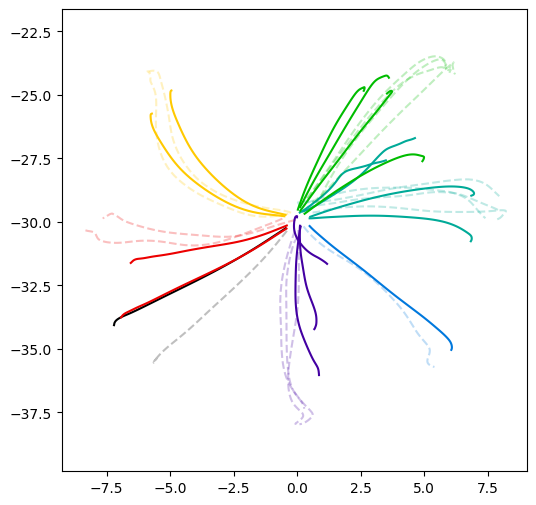

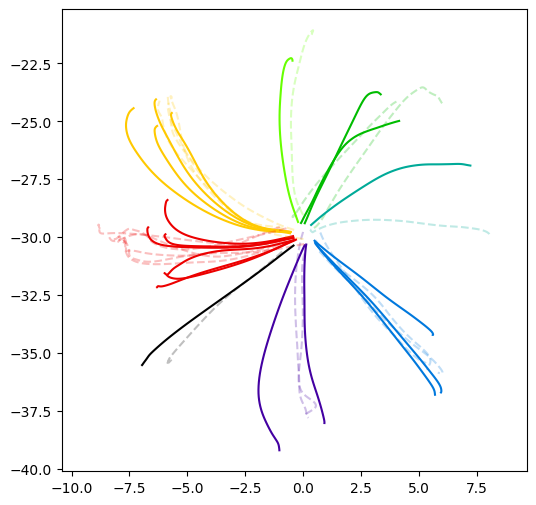

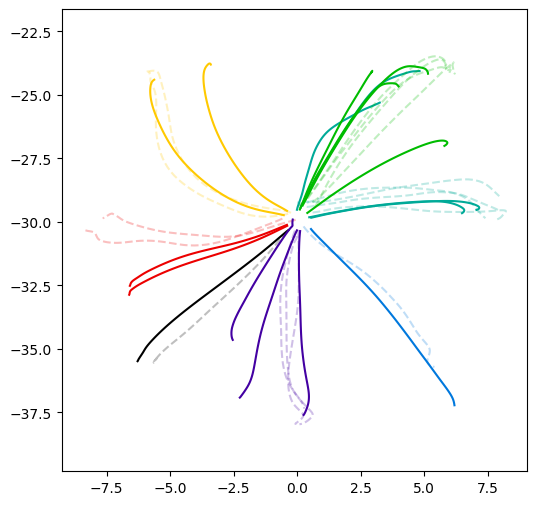

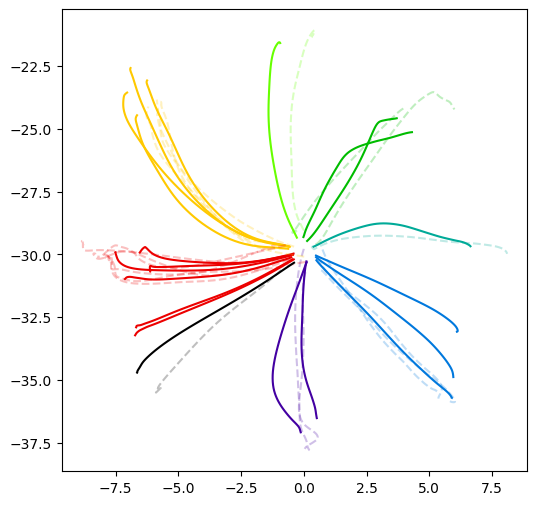

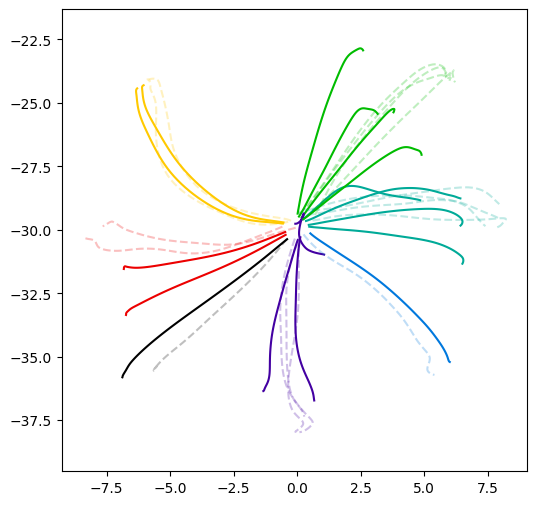

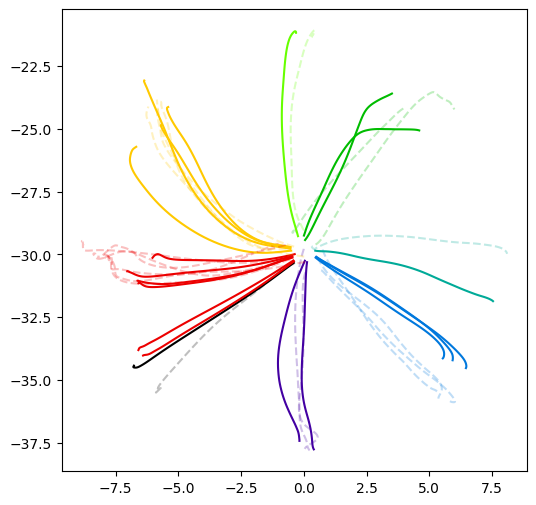

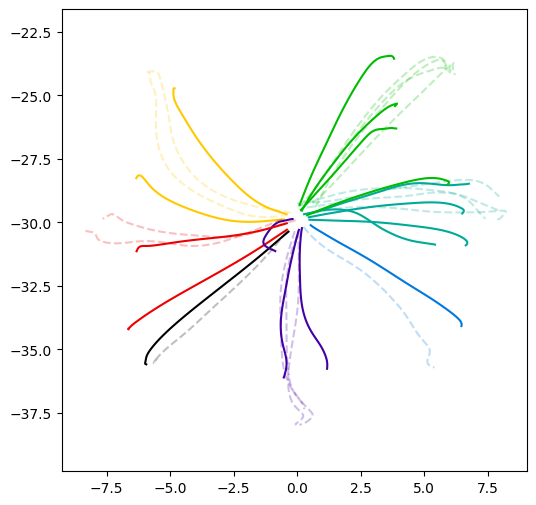

In [74]:
train_r2_list = []
test_r2_list = []

for tot in total:
    model = load_qmodel(f"lfad{tot}bitssgd_qweights.h5" ,compile=False)
    print("eval: {} bits".format(tot))
    # factors
    layer_names=list(layer.name for layer in model.layers)
    factors_layer_name = [s for s in layer_names if s.startswith('q_act3_postfactor')][0]
    factors_layer = model.get_layer(factors_layer_name)
    z_model = Model(model.inputs,  factors_layer.output)
    #z_model.summary()
    pred_z_train =  z_model.predict([x_train, inputs2decoder_train])
    
    X = np.transpose(pred_z_train[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z_train.shape[0], -1))
    y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))


    reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
    print(reg.score(X, y))
    
    beh_fit = reg.predict(X)
    b = np.zeros_like(behavioural_data)
    b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
    b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

    b_reshape = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
    behavioural_data_reshape  = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
    r2 = r2_score(behavioural_data_reshape , b_reshape)
    print('{} bits R2 score train behaviour: {:.3%}'.format(tot, r2))
    train_r2_list.append(r2)
    print()

    plt.figure(figsize=(6,6));
    plot_behaviour(b, behavioural_data, direction_index_train, num=20)

    # test
    pred_z_test =  z_model.predict([x_test, inputs2decoder_test])
    
    Xt = np.transpose(pred_z_test[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z_test.shape[0], -1))
    yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
    print(reg.score(Xt, yt))
    
    
    beh_fit_test = reg.predict(Xt)
    b_t = np.zeros_like(test_behavioural_data)
    b_t[:,:,0] = beh_fit_test[:,:test_behavioural_data.shape[1]]
    b_t[:,:,1] = beh_fit_test[:,test_behavioural_data.shape[1]:]

    Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
    yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
    test_r2 = r2_score( yt, Xt)
    print('{} bits R2 score test behaviour: {:.3%}'.format(tot, test_r2))
    test_r2_list.append(test_r2)
    print()

    plt.figure(figsize=(6,6));
    plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)

In [75]:
train_r2_list

[0.1297552383244111,
 0.4497497148996997,
 0.8911403938105558,
 0.8844891925641292,
 0.8928781716843734,
 0.8816398097619312]

In [76]:
test_r2_list

[-0.18337421449295502,
 0.06569709985408122,
 0.8135659527778659,
 0.8537394152989989,
 0.8388153034186713,
 0.8003111575002627]

"\nplt.subplot(222)\nics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(pred_latent)\nplt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_test])\nplt.axis('equal')\nplt.xlabel('T-SNE factor 1')\nplt.ylabel('T-SNE factor 2')\nplt.title('Factors')\n"

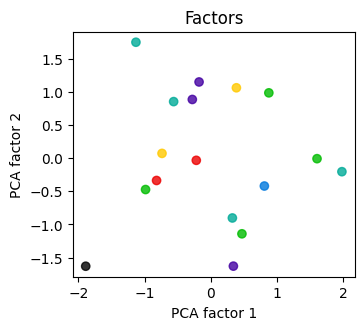

In [36]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(pred_latent)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_test])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors')
'''
plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(pred_latent)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_test])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')
'''

# factors

In [37]:
z_model = Model(model.inputs, model.get_layer('q_act3_postfactor').output)

In [38]:
pred_z =  z_model.predict([test_neural_data.astype('float'), inputs2decoder_val])

C:\Users\rayja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


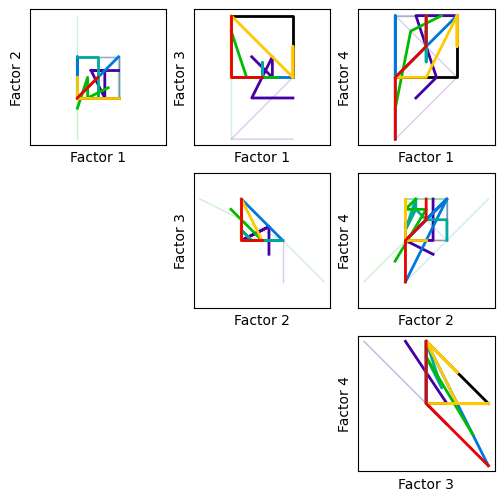

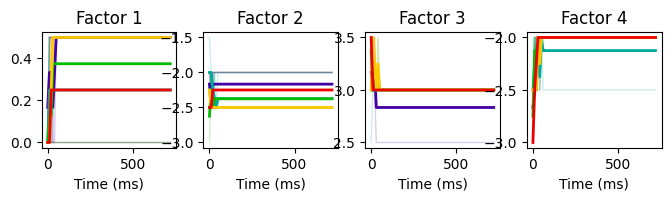

In [39]:
# latent factors
plt.figure(figsize=(6,6))
plot_all_2factors(pred_z, direction_index_test)
plt.figure(figsize=(8,1.5))
plot_all_1factors(pred_z, direction_index_test)


In [48]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)



Xt = np.transpose(pred_z[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(fit_intercept=True).fit(Xt, yt)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

0.5505567974389673


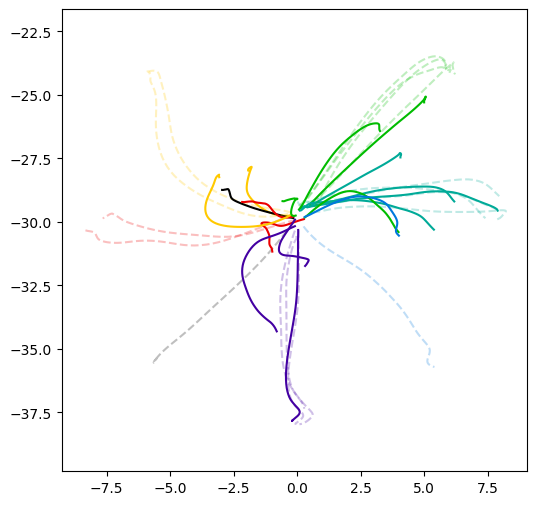

In [49]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)
# plot_behaviour(b, behavioural_data, direction_index_train)

In [50]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 55.056%


## Test data

In [ ]:
log_f_t, (g0_t, mean_t, logvar_t), z_t = \
    model(test_neural_data.astype('float'), training=False)

In [ ]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


In [ ]:
# relevant factors
plt.figure(figsize=(6,6))
plot_all_2factors(z_t, direction_index_test)
# relevant factors
plt.figure(figsize=(8,1.5))
plot_all_1factors(z_t, direction_index_test)


In [ ]:


X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = np.transpose(z_t.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

In [ ]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)
# plot_behaviour(b, behavioural_data, direction_index_train)

In [ ]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

# Trial-averaged firing rates and predictions
Computed from test+train data for better averages

In [ ]:
from sklearn.metrics import mean_squared_error
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
a = []
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]

    for i_n,n in enumerate(range(0,70)):
        ax = fig.add_subplot(8, 70, i*70+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        data_mean = np.mean(data,axis=0)
        data_mean_test = np.mean(data,axis=0)[:,n]
#         print("n",n)
#         print(pred.shape)
#         print(data_mean_test.shape)
        
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        pred_test = np.mean(pred,axis=0)
#         print(pred_test.shape)

        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)
        
        data4mse = data_mean_test
        pred4mse = pred_test
        diff = mean_squared_error(data4mse,pred4mse)
        a.append(diff)
        


In [ ]:
print(sum(a) / len(a))
print(max(a))
print(min(a))
print(log_f.shape)

In [ ]:
d_all = dataset['test_target_direction']

d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d_all)).index(i) for i in d])
direction_index_all =direction_index_test
print(direction_index_all.shape)